100%|██████████| 234/234 [00:01<00:00, 119.76it/s]
/tmp/ipykernel_158289/2191757718.py:255: UserWarning: No contour levels were found within the data range.
  contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)


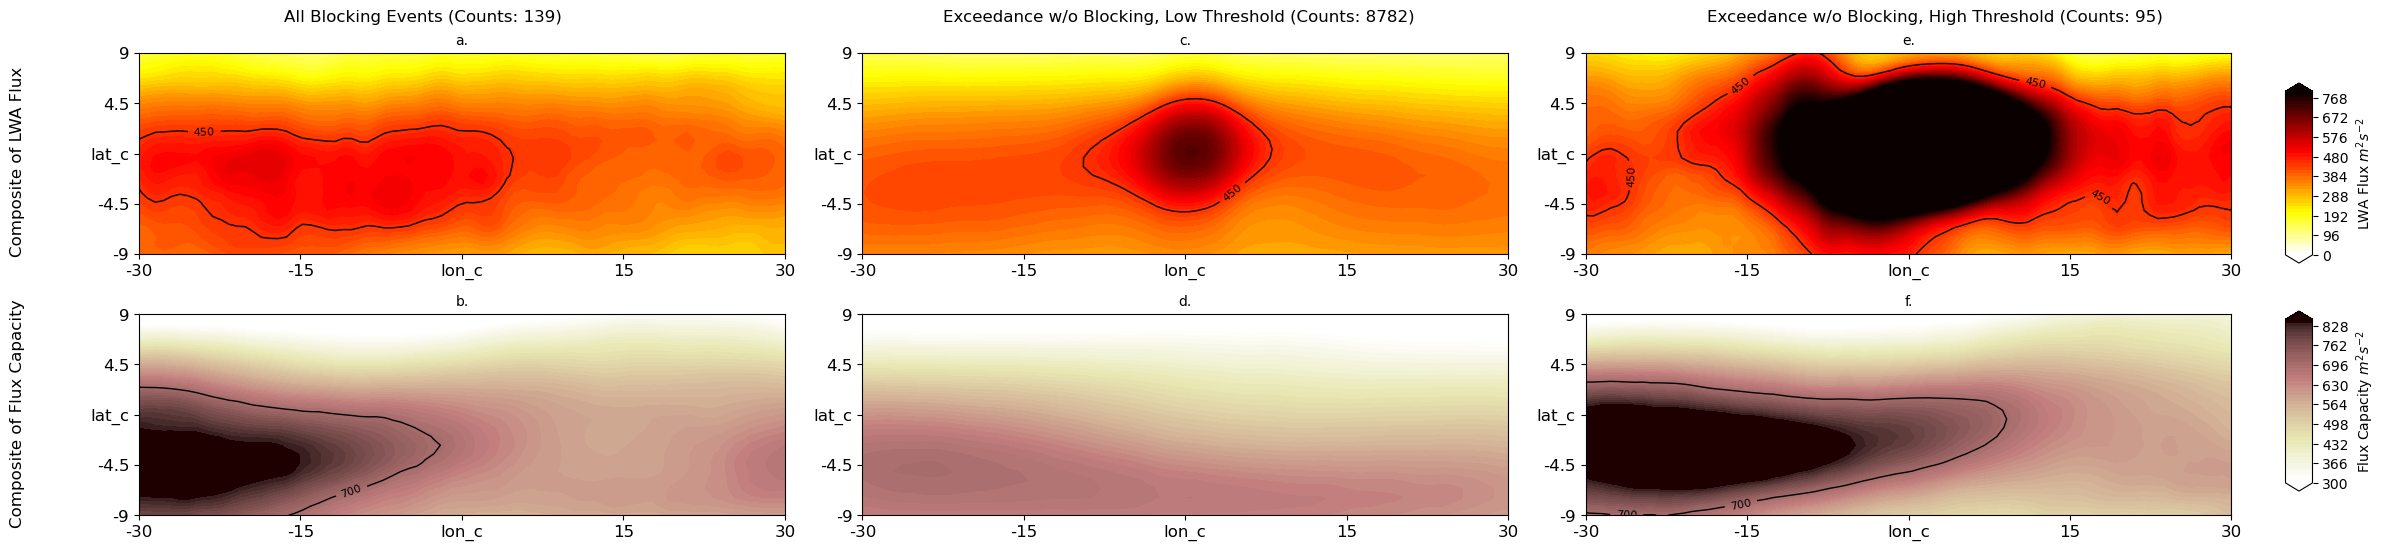

In [8]:
### FIG3 0509 ver - contourf, different cmap, 3 columns

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block1 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    extracted_block2 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block1[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            extracted_block2[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1_flux = np.percentile(extracted_block1, 2)
    percentile_99_flux = np.percentile(extracted_block1, 98)
    extracted_block1 = np.clip(extracted_block1, percentile_1_flux, percentile_99_flux)
    
    percentile_1_cap = np.percentile(extracted_block2, 2)
    percentile_99_cap = np.percentile(extracted_block2, 98)
    extracted_block2 = np.clip(extracted_block2, percentile_1_cap, percentile_99_cap)
    return event_type, extracted_block1, extracted_block2, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV for regular analysis
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')

# Read the results CSV for the high threshold analysis
results_df_high_threshold = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221_high_threshold_1200/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite1_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite1_heatmap_non_match = np.zeros((24, 80))
composite1_heatmap_exceedance = np.zeros((24, 80))
composite1_heatmap_both = np.zeros((24, 80))

# Initialize separate heatmaps for each event type
composite2_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite2_heatmap_non_match = np.zeros((24, 80))
composite2_heatmap_exceedance = np.zeros((24, 80))
composite2_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Initialize separate heatmap_high_thresholds for each event type
composite1_heatmap_high_threshold_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite1_heatmap_high_threshold_non_match = np.zeros((24, 80))
composite1_heatmap_high_threshold_exceedance = np.zeros((24, 80))
composite1_heatmap_high_threshold_both = np.zeros((24, 80))

# Initialize separate heatmap_high_thresholds for each event type
composite2_heatmap_high_threshold_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite2_heatmap_high_threshold_non_match = np.zeros((24, 80))
composite2_heatmap_high_threshold_exceedance = np.zeros((24, 80))
composite2_heatmap_high_threshold_both = np.zeros((24, 80))

# Initialize separate Heaviside_high_threshold blocks for each event type
composite_Heaviside_high_threshold_match = np.zeros((24, 80))
composite_Heaviside_high_threshold_non_match = np.zeros((24, 80))
composite_Heaviside_high_threshold_exceedance = np.zeros((24, 80))
composite_Heaviside_high_threshold_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0
count_high_threshold_match, count_high_threshold_non_match, count_high_threshold_exceedance, count_high_threshold_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block1, block2, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite1_heatmap_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite1_heatmap_non_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_non_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite1_heatmap_exceedance += block1
        composite2_heatmap_exceedance += block2
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite1_heatmap_match /= count_match if count_match else 1
composite1_heatmap_non_match /= count_non_match if count_non_match else 1
composite1_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite1_heatmap_both /= count_both if count_both else 1

composite2_heatmap_match /= count_match if count_match else 1
composite2_heatmap_non_match /= count_non_match if count_non_match else 1
composite2_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite2_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Use Joblib to process events in parallel and extract the blocks for both datasets
for row in tqdm(results_df_high_threshold.itertuples(index=False), total=len(results_df_high_threshold)):
    event_type, block1, block2, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )

    if event_type == 'Match':
        composite1_heatmap_high_threshold_match += block1
        composite1_heatmap_high_threshold_both += block1
        composite2_heatmap_high_threshold_match += block2
        composite2_heatmap_high_threshold_both += block2
        composite_Heaviside_high_threshold_match += Heaviside
        composite_Heaviside_high_threshold_both += Heaviside
        count_high_threshold_match += 1
        count_high_threshold_both += 1
    elif event_type == 'Non-Match':
        composite1_heatmap_high_threshold_non_match += block1
        composite1_heatmap_high_threshold_both += block1
        composite2_heatmap_high_threshold_non_match += block2
        composite2_heatmap_high_threshold_both += block2
        composite_Heaviside_high_threshold_non_match += Heaviside
        composite_Heaviside_high_threshold_both += Heaviside
        count_high_threshold_non_match += 1
        count_high_threshold_both += 1
    elif event_type == 'Exceedance':
        composite1_heatmap_high_threshold_exceedance += block1
        composite2_heatmap_high_threshold_exceedance += block2
        composite_Heaviside_high_threshold_exceedance += Heaviside
        count_high_threshold_exceedance += 1

# Calculate the averages for the composite heatmap_high_threshold
composite1_heatmap_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite1_heatmap_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite1_heatmap_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite1_heatmap_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1

composite2_heatmap_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite2_heatmap_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite2_heatmap_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite2_heatmap_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1

composite_Heaviside_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite_Heaviside_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite_Heaviside_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite_Heaviside_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1



# Updated plotting function that takes a cmap parameter
def plot_composite_heatmap(ax, data, title, event_count, norm, levels, cmap):
    lon = np.linspace(-30, 30, data.shape[1])
    lat = np.linspace(-9, 9, data.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)
    contour = ax.contourf(Lon, Lat, data, levels=norm.boundaries, cmap=cmap, norm=norm, extend='both')
    contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f', colors='black')
    ax.set_title(f"{title}", fontsize=10)
    ax.set_xticks([-30, -15, 0, 15, 30])
    ax.set_yticks([-9, -4.5, 0, 4.5, 9])
    ax.set_xticklabels(['-30', '-15', 'lon_c', '15', '30'], fontsize=12)
    ax.set_yticklabels(['-9', '-4.5', 'lat_c', '4.5', '9'], fontsize=12)
    return contour

# Setup for plotting
fig = plt.figure(figsize=(27, 6))
gs = gridspec.GridSpec(2, 3)

# Color maps
cmap_upper = 'hot_r'
cmap_lower = 'pink_r'

# Norms for the upper and lower rows
norm_upper = BoundaryNorm(np.linspace(0, 800, 51), ncolors=256, clip=True)
norm_lower = BoundaryNorm(np.linspace(300, 850, 51), ncolors=256, clip=True)

# Upper row plots
ax1 = fig.add_subplot(gs[0, 0])
contour1 = plot_composite_heatmap(ax1, composite1_heatmap_both, r"a.", count_both, norm=norm_upper, levels=[450], cmap=cmap_upper)
ax2 = fig.add_subplot(gs[0, 1])
contour2 = plot_composite_heatmap(ax2, composite1_heatmap_exceedance, r"c.", count_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper)

# Lower row plots
ax3 = fig.add_subplot(gs[1, 0])
contour3 = plot_composite_heatmap(ax3, composite2_heatmap_both, r"b.", count_both, norm=norm_lower, levels=[700], cmap=cmap_lower)
ax4 = fig.add_subplot(gs[1, 1])
contour4 = plot_composite_heatmap(ax4, composite2_heatmap_exceedance, r"d.", count_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)


# Additional plotting of the new column
ax5 = fig.add_subplot(gs[0, 2])
contour5 = plot_composite_heatmap(ax5, composite1_heatmap_high_threshold_exceedance, r"e.", count_high_threshold_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper)

# Additional plotting of the new column
ax6 = fig.add_subplot(gs[1, 2])
contour6 = plot_composite_heatmap(ax6, composite2_heatmap_high_threshold_exceedance, r"f.", count_high_threshold_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)

# Colorbars
cbar_ax1 = fig.add_axes([0.92, 0.53, 0.01, 0.3])
fig.colorbar(contour1, cax=cbar_ax1).set_label("LWA Flux $m^2s^{-2}$")
cbar_ax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])
fig.colorbar(contour3, cax=cbar_ax2).set_label("Flux Capacity $m^2s^{-2}$")


# Adjust spacing and add titles
plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.figtext(0.23, 0.94, f'All Blocking Events (Counts: {count_both})', ha='center', va='center', fontsize=12)
plt.figtext(0.51, 0.94, f'Exceedance w/o Blocking, Low Threshold (Counts: {count_exceedance})', ha='center', va='center', fontsize=12)
plt.figtext(0.79, 0.94, f'Exceedance w/o Blocking, High Threshold (Counts: {count_high_threshold_exceedance})', ha='center', va='center', fontsize=12)
plt.figtext(0.08, 0.7, 'Composite of LWA Flux', ha='center', va='center', fontsize=12, rotation='vertical')
plt.figtext(0.08, 0.28, 'Composite of Flux Capacity', ha='center', va='center', fontsize=12, rotation='vertical')

plt.show()

100%|██████████| 234/234 [00:03<00:00, 69.27it/s] 
/tmp/ipykernel_4149562/3051942031.py:263: UserWarning: No contour levels were found within the data range.
  contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)


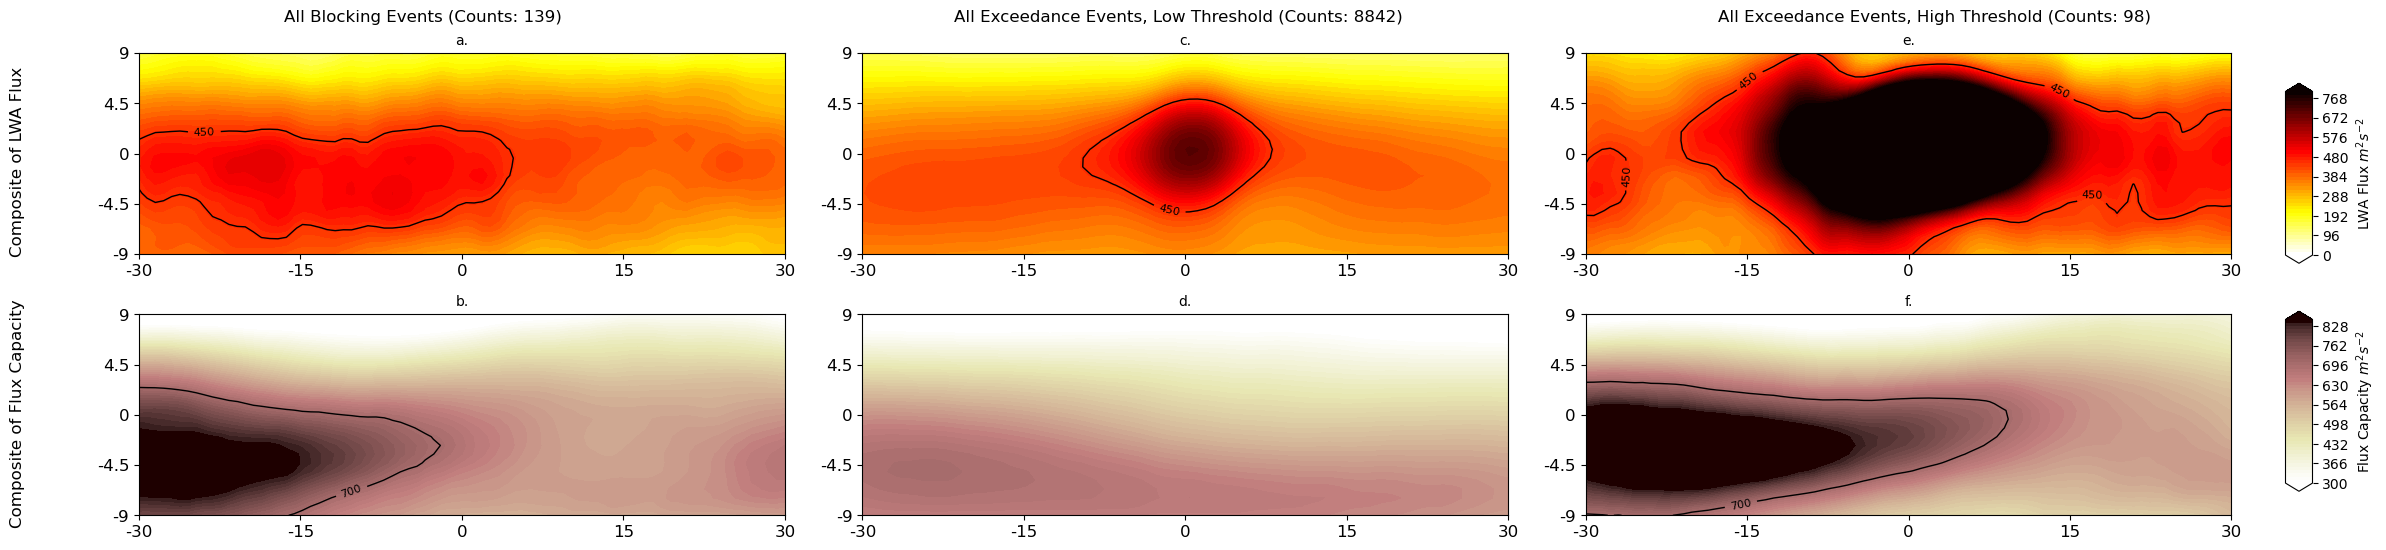

In [2]:
### FIG3 0521 ver - contourf, different cmap, 3 columns

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block1 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    extracted_block2 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block1[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            extracted_block2[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1_flux = np.percentile(extracted_block1, 2)
    percentile_99_flux = np.percentile(extracted_block1, 98)
    extracted_block1 = np.clip(extracted_block1, percentile_1_flux, percentile_99_flux)
    
    percentile_1_cap = np.percentile(extracted_block2, 2)
    percentile_99_cap = np.percentile(extracted_block2, 98)
    extracted_block2 = np.clip(extracted_block2, percentile_1_cap, percentile_99_cap)
    return event_type, extracted_block1, extracted_block2, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV for regular analysis
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')

# Read the results CSV for the high threshold analysis
results_df_high_threshold = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221_high_threshold_1200/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite1_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite1_heatmap_non_match = np.zeros((24, 80))
composite1_heatmap_exceedance = np.zeros((24, 80))
composite1_heatmap_both = np.zeros((24, 80))

# Initialize separate heatmaps for each event type
composite2_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite2_heatmap_non_match = np.zeros((24, 80))
composite2_heatmap_exceedance = np.zeros((24, 80))
composite2_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Initialize separate heatmap_high_thresholds for each event type
composite1_heatmap_high_threshold_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite1_heatmap_high_threshold_non_match = np.zeros((24, 80))
composite1_heatmap_high_threshold_exceedance = np.zeros((24, 80))
composite1_heatmap_high_threshold_both = np.zeros((24, 80))

# Initialize separate heatmap_high_thresholds for each event type
composite2_heatmap_high_threshold_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite2_heatmap_high_threshold_non_match = np.zeros((24, 80))
composite2_heatmap_high_threshold_exceedance = np.zeros((24, 80))
composite2_heatmap_high_threshold_both = np.zeros((24, 80))

# Initialize separate Heaviside_high_threshold blocks for each event type
composite_Heaviside_high_threshold_match = np.zeros((24, 80))
composite_Heaviside_high_threshold_non_match = np.zeros((24, 80))
composite_Heaviside_high_threshold_exceedance = np.zeros((24, 80))
composite_Heaviside_high_threshold_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0
count_high_threshold_match, count_high_threshold_non_match, count_high_threshold_exceedance, count_high_threshold_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block1, block2, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite1_heatmap_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        composite1_heatmap_exceedance += block1
        composite2_heatmap_exceedance += block2
        composite_Heaviside_exceedance += Heaviside
        count_match += 1
        count_exceedance += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite1_heatmap_non_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_non_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite1_heatmap_exceedance += block1
        composite2_heatmap_exceedance += block2
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite1_heatmap_match /= count_match if count_match else 1
composite1_heatmap_non_match /= count_non_match if count_non_match else 1
composite1_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite1_heatmap_both /= count_both if count_both else 1

composite2_heatmap_match /= count_match if count_match else 1
composite2_heatmap_non_match /= count_non_match if count_non_match else 1
composite2_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite2_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Use Joblib to process events in parallel and extract the blocks for both datasets
for row in tqdm(results_df_high_threshold.itertuples(index=False), total=len(results_df_high_threshold)):
    event_type, block1, block2, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )

    if event_type == 'Match':
        composite1_heatmap_high_threshold_match += block1
        composite1_heatmap_high_threshold_both += block1
        composite2_heatmap_high_threshold_match += block2
        composite2_heatmap_high_threshold_both += block2
        composite_Heaviside_high_threshold_match += Heaviside
        composite_Heaviside_high_threshold_both += Heaviside
        composite1_heatmap_high_threshold_exceedance += block1
        composite2_heatmap_high_threshold_exceedance += block2
        composite_Heaviside_high_threshold_exceedance += Heaviside
        count_high_threshold_exceedance += 1
        count_high_threshold_match += 1
        count_high_threshold_both += 1
    elif event_type == 'Non-Match':
        composite1_heatmap_high_threshold_non_match += block1
        composite1_heatmap_high_threshold_both += block1
        composite2_heatmap_high_threshold_non_match += block2
        composite2_heatmap_high_threshold_both += block2
        composite_Heaviside_high_threshold_non_match += Heaviside
        composite_Heaviside_high_threshold_both += Heaviside
        count_high_threshold_non_match += 1
        count_high_threshold_both += 1
    elif event_type == 'Exceedance':
        composite1_heatmap_high_threshold_exceedance += block1
        composite2_heatmap_high_threshold_exceedance += block2
        composite_Heaviside_high_threshold_exceedance += Heaviside
        count_high_threshold_exceedance += 1

# Calculate the averages for the composite heatmap_high_threshold
composite1_heatmap_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite1_heatmap_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite1_heatmap_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite1_heatmap_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1

composite2_heatmap_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite2_heatmap_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite2_heatmap_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite2_heatmap_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1

composite_Heaviside_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite_Heaviside_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite_Heaviside_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite_Heaviside_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1



# Updated plotting function that takes a cmap parameter
def plot_composite_heatmap(ax, data, title, event_count, norm, levels, cmap):
    lon = np.linspace(-30, 30, data.shape[1])
    lat = np.linspace(-9, 9, data.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)
    contour = ax.contourf(Lon, Lat, data, levels=norm.boundaries, cmap=cmap, norm=norm, extend='both')
    contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f', colors='black')
    ax.set_title(f"{title}", fontsize=10)
    ax.set_xticks([-30, -15, 0, 15, 30])
    ax.set_yticks([-9, -4.5, 0, 4.5, 9])
    ax.set_xticklabels(['-30', '-15', '0', '15', '30'], fontsize=12)
    ax.set_yticklabels(['-9', '-4.5', '0', '4.5', '9'], fontsize=12)
    return contour

# Setup for plotting
fig = plt.figure(figsize=(27, 6))
gs = gridspec.GridSpec(2, 3)

# Color maps
cmap_upper = 'hot_r'
cmap_lower = 'pink_r'

# Norms for the upper and lower rows
norm_upper = BoundaryNorm(np.linspace(0, 800, 51), ncolors=256, clip=True)
norm_lower = BoundaryNorm(np.linspace(300, 850, 51), ncolors=256, clip=True)

# Upper row plots
ax1 = fig.add_subplot(gs[0, 0])
contour1 = plot_composite_heatmap(ax1, composite1_heatmap_both, r"a.", count_both, norm=norm_upper, levels=[450], cmap=cmap_upper)
ax2 = fig.add_subplot(gs[0, 1])
contour2 = plot_composite_heatmap(ax2, composite1_heatmap_exceedance, r"c.", count_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper)

# Lower row plots
ax3 = fig.add_subplot(gs[1, 0])
contour3 = plot_composite_heatmap(ax3, composite2_heatmap_both, r"b.", count_both, norm=norm_lower, levels=[700], cmap=cmap_lower)
ax4 = fig.add_subplot(gs[1, 1])
contour4 = plot_composite_heatmap(ax4, composite2_heatmap_exceedance, r"d.", count_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)


# Additional plotting of the new column
ax5 = fig.add_subplot(gs[0, 2])
contour5 = plot_composite_heatmap(ax5, composite1_heatmap_high_threshold_exceedance, r"e.", count_high_threshold_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper)

# Additional plotting of the new column
ax6 = fig.add_subplot(gs[1, 2])
contour6 = plot_composite_heatmap(ax6, composite2_heatmap_high_threshold_exceedance, r"f.", count_high_threshold_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)

# Colorbars
cbar_ax1 = fig.add_axes([0.92, 0.53, 0.01, 0.3])
fig.colorbar(contour1, cax=cbar_ax1).set_label("LWA Flux $m^2s^{-2}$")
cbar_ax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])
fig.colorbar(contour3, cax=cbar_ax2).set_label("Flux Capacity $m^2s^{-2}$")


# Adjust spacing and add titles
plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.figtext(0.23, 0.94, f'All Blocking Events (Counts: {count_both})', ha='center', va='center', fontsize=12)
plt.figtext(0.51, 0.94, f'All Exceedance Events, Low Threshold (Counts: {count_exceedance})', ha='center', va='center', fontsize=12)
plt.figtext(0.79, 0.94, f'All Exceedance Events, High Threshold (Counts: {count_high_threshold_exceedance})', ha='center', va='center', fontsize=12)
plt.figtext(0.08, 0.7, 'Composite of LWA Flux', ha='center', va='center', fontsize=12, rotation='vertical')
plt.figtext(0.08, 0.28, 'Composite of Flux Capacity', ha='center', va='center', fontsize=12, rotation='vertical')

plt.show()

100%|██████████| 234/234 [00:01<00:00, 122.85it/s]
/tmp/ipykernel_4149562/2644713013.py:263: UserWarning: No contour levels were found within the data range.
  contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)


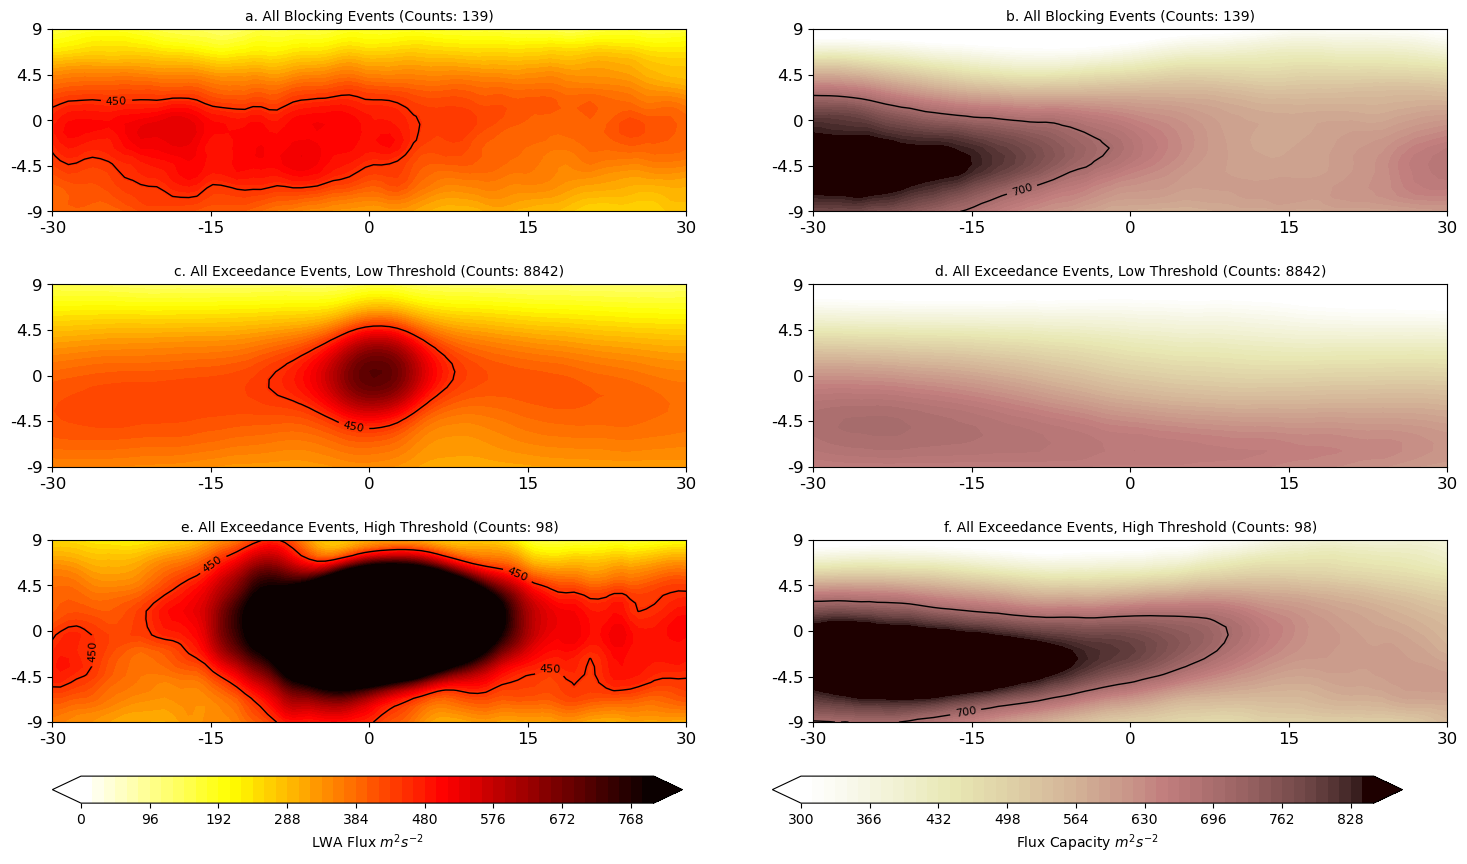

In [14]:
### FIG3 0521 ver - contourf, different cmap, 3 columns

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block1 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    extracted_block2 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block1[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            extracted_block2[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1_flux = np.percentile(extracted_block1, 2)
    percentile_99_flux = np.percentile(extracted_block1, 98)
    extracted_block1 = np.clip(extracted_block1, percentile_1_flux, percentile_99_flux)
    
    percentile_1_cap = np.percentile(extracted_block2, 2)
    percentile_99_cap = np.percentile(extracted_block2, 98)
    extracted_block2 = np.clip(extracted_block2, percentile_1_cap, percentile_99_cap)
    return event_type, extracted_block1, extracted_block2, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV for regular analysis
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')

# Read the results CSV for the high threshold analysis
results_df_high_threshold = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221_high_threshold_1200/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite1_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite1_heatmap_non_match = np.zeros((24, 80))
composite1_heatmap_exceedance = np.zeros((24, 80))
composite1_heatmap_both = np.zeros((24, 80))

# Initialize separate heatmaps for each event type
composite2_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite2_heatmap_non_match = np.zeros((24, 80))
composite2_heatmap_exceedance = np.zeros((24, 80))
composite2_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Initialize separate heatmap_high_thresholds for each event type
composite1_heatmap_high_threshold_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite1_heatmap_high_threshold_non_match = np.zeros((24, 80))
composite1_heatmap_high_threshold_exceedance = np.zeros((24, 80))
composite1_heatmap_high_threshold_both = np.zeros((24, 80))

# Initialize separate heatmap_high_thresholds for each event type
composite2_heatmap_high_threshold_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite2_heatmap_high_threshold_non_match = np.zeros((24, 80))
composite2_heatmap_high_threshold_exceedance = np.zeros((24, 80))
composite2_heatmap_high_threshold_both = np.zeros((24, 80))

# Initialize separate Heaviside_high_threshold blocks for each event type
composite_Heaviside_high_threshold_match = np.zeros((24, 80))
composite_Heaviside_high_threshold_non_match = np.zeros((24, 80))
composite_Heaviside_high_threshold_exceedance = np.zeros((24, 80))
composite_Heaviside_high_threshold_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0
count_high_threshold_match, count_high_threshold_non_match, count_high_threshold_exceedance, count_high_threshold_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block1, block2, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite1_heatmap_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        composite1_heatmap_exceedance += block1
        composite2_heatmap_exceedance += block2
        composite_Heaviside_exceedance += Heaviside
        count_match += 1
        count_exceedance += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite1_heatmap_non_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_non_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite1_heatmap_exceedance += block1
        composite2_heatmap_exceedance += block2
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite1_heatmap_match /= count_match if count_match else 1
composite1_heatmap_non_match /= count_non_match if count_non_match else 1
composite1_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite1_heatmap_both /= count_both if count_both else 1

composite2_heatmap_match /= count_match if count_match else 1
composite2_heatmap_non_match /= count_non_match if count_non_match else 1
composite2_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite2_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Use Joblib to process events in parallel and extract the blocks for both datasets
for row in tqdm(results_df_high_threshold.itertuples(index=False), total=len(results_df_high_threshold)):
    event_type, block1, block2, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )

    if event_type == 'Match':
        composite1_heatmap_high_threshold_match += block1
        composite1_heatmap_high_threshold_both += block1
        composite2_heatmap_high_threshold_match += block2
        composite2_heatmap_high_threshold_both += block2
        composite_Heaviside_high_threshold_match += Heaviside
        composite_Heaviside_high_threshold_both += Heaviside
        composite1_heatmap_high_threshold_exceedance += block1
        composite2_heatmap_high_threshold_exceedance += block2
        composite_Heaviside_high_threshold_exceedance += Heaviside
        count_high_threshold_exceedance += 1
        count_high_threshold_match += 1
        count_high_threshold_both += 1
    elif event_type == 'Non-Match':
        composite1_heatmap_high_threshold_non_match += block1
        composite1_heatmap_high_threshold_both += block1
        composite2_heatmap_high_threshold_non_match += block2
        composite2_heatmap_high_threshold_both += block2
        composite_Heaviside_high_threshold_non_match += Heaviside
        composite_Heaviside_high_threshold_both += Heaviside
        count_high_threshold_non_match += 1
        count_high_threshold_both += 1
    elif event_type == 'Exceedance':
        composite1_heatmap_high_threshold_exceedance += block1
        composite2_heatmap_high_threshold_exceedance += block2
        composite_Heaviside_high_threshold_exceedance += Heaviside
        count_high_threshold_exceedance += 1

# Calculate the averages for the composite heatmap_high_threshold
composite1_heatmap_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite1_heatmap_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite1_heatmap_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite1_heatmap_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1

composite2_heatmap_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite2_heatmap_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite2_heatmap_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite2_heatmap_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1

composite_Heaviside_high_threshold_match /= count_high_threshold_match if count_high_threshold_match else 1
composite_Heaviside_high_threshold_non_match /= count_high_threshold_non_match if count_high_threshold_non_match else 1
composite_Heaviside_high_threshold_exceedance /= count_high_threshold_exceedance if count_high_threshold_exceedance else 1
composite_Heaviside_high_threshold_both /= count_high_threshold_both if count_high_threshold_both else 1



# Updated plotting function that takes a cmap parameter
def plot_composite_heatmap(ax, data, title, event_count, norm, levels, cmap):
    lon = np.linspace(-30, 30, data.shape[1])
    lat = np.linspace(-9, 9, data.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)
    contour = ax.contourf(Lon, Lat, data, levels=norm.boundaries, cmap=cmap, norm=norm, extend='both')
    contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f', colors='black')
    ax.set_title(f"{title}", fontsize=10)
    ax.set_xticks([-30, -15, 0, 15, 30])
    ax.set_yticks([-9, -4.5, 0, 4.5, 9])
    ax.set_xticklabels(['-30', '-15', '0', '15', '30'], fontsize=12)
    ax.set_yticklabels(['-9', '-4.5', '0', '4.5', '9'], fontsize=12)
    return contour

# Setup for plotting
fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], hspace=0.4) 

# Color maps
cmap_upper = 'hot_r'
cmap_lower = 'pink_r'

# Norms for the upper and lower rows
norm_upper = BoundaryNorm(np.linspace(0, 800, 51), ncolors=256, clip=True)
norm_lower = BoundaryNorm(np.linspace(300, 850, 51), ncolors=256, clip=True)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
contour1 = plot_composite_heatmap(ax1, composite1_heatmap_both, f"a. All Blocking Events (Counts: {count_both})", count_both, norm=norm_upper, levels=[450], cmap=cmap_upper)
ax2 = fig.add_subplot(gs[1, 0])
contour2 = plot_composite_heatmap(ax2, composite1_heatmap_exceedance, f"c. All Exceedance Events, Low Threshold (Counts: {count_exceedance})", count_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper)

ax3 = fig.add_subplot(gs[0, 1])
contour3 = plot_composite_heatmap(ax3, composite2_heatmap_both, f"b. All Blocking Events (Counts: {count_both})", count_both, norm=norm_lower, levels=[700], cmap=cmap_lower)
ax4 = fig.add_subplot(gs[1, 1])
contour4 = plot_composite_heatmap(ax4, composite2_heatmap_exceedance, f"d. All Exceedance Events, Low Threshold (Counts: {count_exceedance})", count_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)

ax5 = fig.add_subplot(gs[2, 0])
contour5 = plot_composite_heatmap(ax5, composite1_heatmap_high_threshold_exceedance, f"e. All Exceedance Events, High Threshold (Counts: {count_high_threshold_exceedance})", count_high_threshold_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper)
ax6 = fig.add_subplot(gs[2, 1])
contour6 = plot_composite_heatmap(ax6, composite2_heatmap_high_threshold_exceedance, f"f. All Exceedance Events, High Threshold (Counts: {count_high_threshold_exceedance})", count_high_threshold_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)

# Colorbars at the bottom
cbar_ax1 = fig.add_axes([0.125, 0.02, 0.35, 0.03])  # x position, y position, width, height
fig.colorbar(contour1, cax=cbar_ax1, orientation='horizontal').set_label("LWA Flux $m^2s^{-2}$")
cbar_ax2 = fig.add_axes([0.525, 0.02, 0.35, 0.03])
fig.colorbar(contour3, cax=cbar_ax2, orientation='horizontal').set_label("Flux Capacity $m^2s^{-2}$")

plt.show()

100%|██████████| 8921/8921 [01:07<00:00, 131.58it/s]
/tmp/ipykernel_3327667/1866702860.py:188: UserWarning: No contour levels were found within the data range.
  contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)


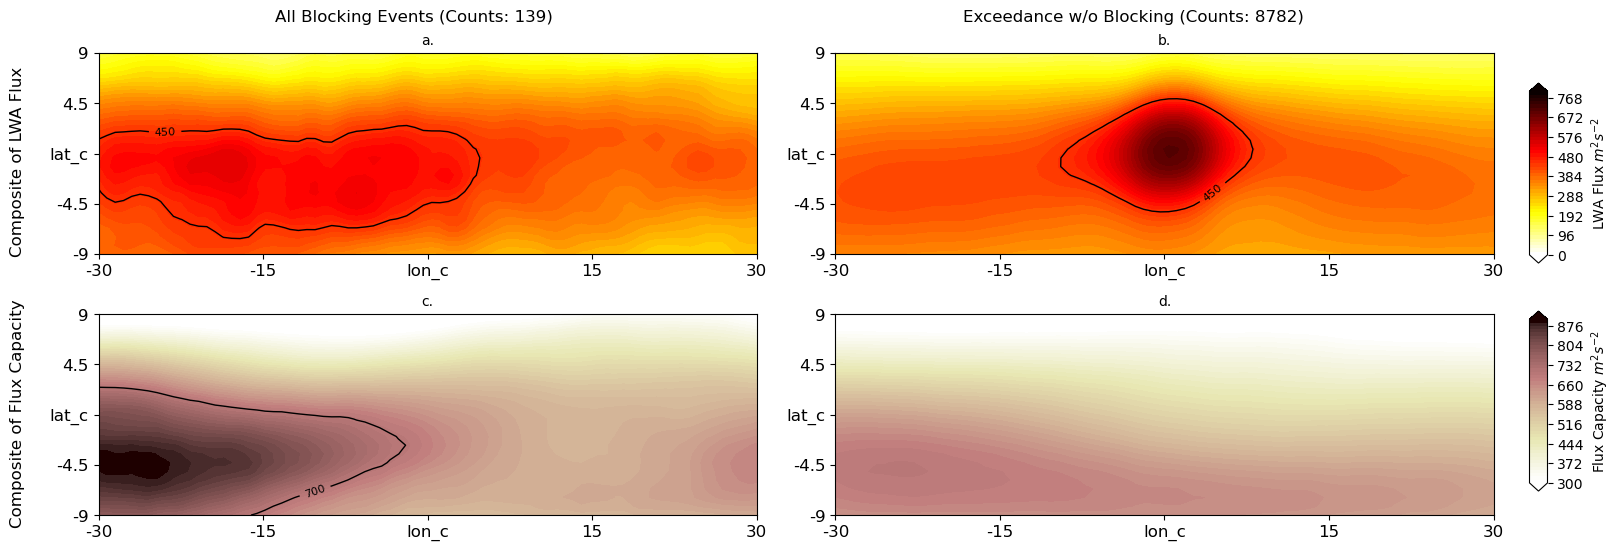

In [5]:
### FIG3 0327 ver - contourf, different cmap

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block1 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    extracted_block2 = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block1[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            extracted_block2[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1_flux = np.percentile(extracted_block1, 2)
    percentile_99_flux = np.percentile(extracted_block1, 98)
    extracted_block1 = np.clip(extracted_block1, percentile_1_flux, percentile_99_flux)
    
    percentile_1_cap = np.percentile(extracted_block2, 2)
    percentile_99_cap = np.percentile(extracted_block2, 98)
    extracted_block2 = np.clip(extracted_block2, percentile_1_cap, percentile_99_cap)
    return event_type, extracted_block1, extracted_block2, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite1_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite1_heatmap_non_match = np.zeros((24, 80))
composite1_heatmap_exceedance = np.zeros((24, 80))
composite1_heatmap_both = np.zeros((24, 80))

# Initialize separate heatmaps for each event type
composite2_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite2_heatmap_non_match = np.zeros((24, 80))
composite2_heatmap_exceedance = np.zeros((24, 80))
composite2_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block1, block2, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite1_heatmap_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite1_heatmap_non_match += block1
        composite1_heatmap_both += block1
        composite2_heatmap_non_match += block2
        composite2_heatmap_both += block2
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite1_heatmap_exceedance += block1
        composite2_heatmap_exceedance += block2
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite1_heatmap_match /= count_match if count_match else 1
composite1_heatmap_non_match /= count_non_match if count_non_match else 1
composite1_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite1_heatmap_both /= count_both if count_both else 1

composite2_heatmap_match /= count_match if count_match else 1
composite2_heatmap_non_match /= count_non_match if count_non_match else 1
composite2_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite2_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


levs1 = np.linspace(0, 800, 51)
norm1 = BoundaryNorm(levs1, ncolors = 256, clip = True)

levs2 = np.linspace(200, 900, 51)
norm2 = BoundaryNorm(levs2, ncolors = 256, clip = True)

# Updated plotting function that takes a cmap parameter
def plot_composite_heatmap(ax, data, title, event_count, norm, levels, cmap):
    lon = np.linspace(-30, 30, data.shape[1])
    lat = np.linspace(-9, 9, data.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)
    contour = ax.contourf(Lon, Lat, data, levels=norm.boundaries, cmap=cmap, norm=norm, extend='both')
    contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f', colors='black')
    ax.set_title(f"{title}", fontsize=10)
    ax.set_xticks([-30, -15, 0, 15, 30])
    ax.set_yticks([-9, -4.5, 0, 4.5, 9])
    ax.set_xticklabels(['-30', '-15', 'lon_c', '15', '30'], fontsize=12)
    ax.set_yticklabels(['-9', '-4.5', 'lat_c', '4.5', '9'], fontsize=12)
    return contour

# Setup for plotting
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 2)

# Color maps
cmap_upper = 'hot_r'
cmap_lower = 'pink_r'

# Norms for the upper and lower rows
norm_upper = BoundaryNorm(np.linspace(0, 800, 51), ncolors=256, clip=True)
norm_lower = BoundaryNorm(np.linspace(300, 900, 51), ncolors=256, clip=True)

# Upper row plots
ax1 = fig.add_subplot(gs[0, 0])
contour1 = plot_composite_heatmap(ax1, composite1_heatmap_both, r"a.", count_both, norm=norm_upper, levels=[450], cmap=cmap_upper)
ax2 = fig.add_subplot(gs[0, 1])
contour2 = plot_composite_heatmap(ax2, composite1_heatmap_exceedance, r"b.", count_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper)

# Lower row plots
ax3 = fig.add_subplot(gs[1, 0])
contour3 = plot_composite_heatmap(ax3, composite2_heatmap_both, r"c.", count_both, norm=norm_lower, levels=[700], cmap=cmap_lower)
ax4 = fig.add_subplot(gs[1, 1])
contour4 = plot_composite_heatmap(ax4, composite2_heatmap_exceedance, r"d.", count_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)

# Colorbars
cbar_ax1 = fig.add_axes([0.92, 0.53, 0.01, 0.3])
fig.colorbar(contour1, cax=cbar_ax1).set_label("LWA Flux $m^2s^{-2}$")
cbar_ax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])
fig.colorbar(contour3, cax=cbar_ax2).set_label("Flux Capacity $m^2s^{-2}$")

# Adjust spacing and add titles
plt.subplots_adjust(wspace=0.12, hspace=0.3)
plt.figtext(0.3, 0.94, f'All Blocking Events (Counts: {count_both})', ha='center', va='center', fontsize=12)
plt.figtext(0.7, 0.94, f'Exceedance w/o Blocking (Counts: {count_exceedance})', ha='center', va='center', fontsize=12)
plt.figtext(0.08, 0.7, 'Composite of LWA Flux', ha='center', va='center', fontsize=12, rotation='vertical')
plt.figtext(0.08, 0.28, 'Composite of Flux Capacity', ha='center', va='center', fontsize=12, rotation='vertical')

plt.show()

100%|██████████| 8921/8921 [17:06<00:00,  8.69it/s] 


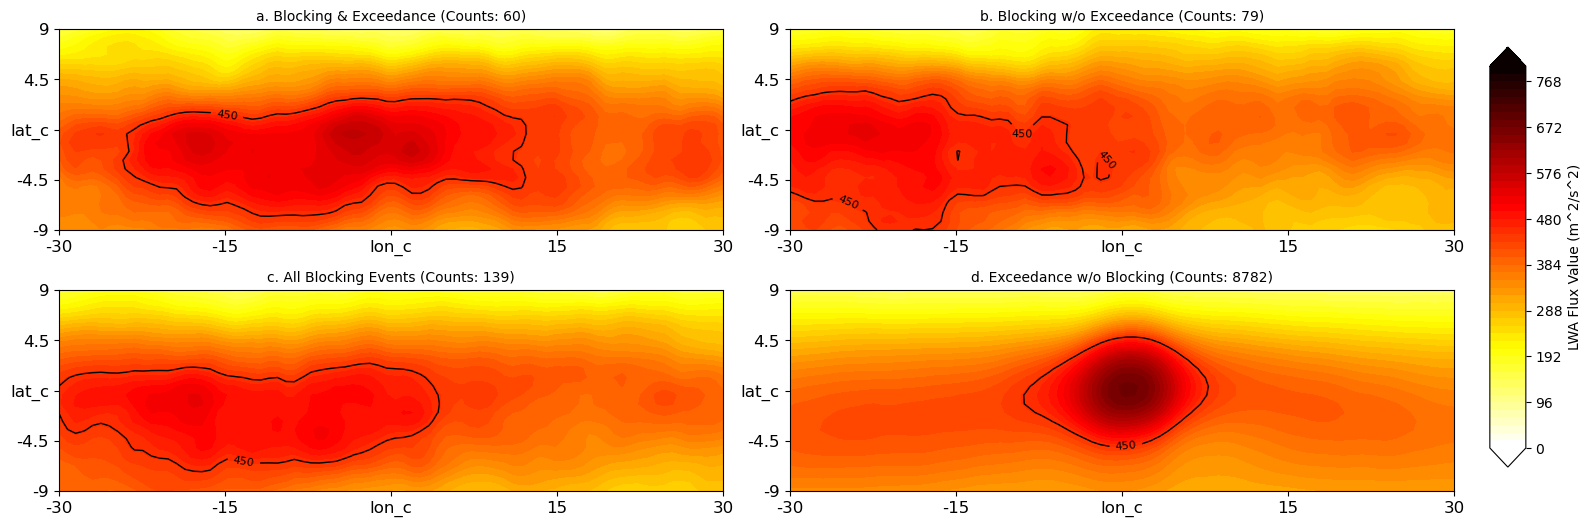

In [19]:
### FIG3 supp low threshold

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1 = np.percentile(extracted_block, 5)
    percentile_99 = np.percentile(extracted_block, 95)
    extracted_block = np.clip(extracted_block, percentile_1, percentile_99)
    return event_type, extracted_block, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Define the function to plot heatmaps
def plot_composite_heatmap(ax, data, title, event_count, norm, levels, cmap):
    lon = np.linspace(-30, 30, data.shape[1])
    lat = np.linspace(-9, 9, data.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)
    contour = ax.contourf(Lon, Lat, data, levels=norm.boundaries, cmap=cmap, norm=norm, extend='both')
    contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f', colors='black')
    ax.set_title(f"{title}", fontsize=10)
    ax.set_xticks([-30, -15, 0, 15, 30])
    ax.set_yticks([-9, -4.5, 0, 4.5, 9])
    ax.set_xticklabels(['-30', '-15', 'lon_c', '15', '30'], fontsize=12)
    ax.set_yticklabels(['-9', '-4.5', 'lat_c', '4.5', '9'], fontsize=12)
    return contour

# Setup for plotting
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 2)

# Color maps
cmap_upper = 'hot_r'
cmap_lower = 'pink_r'

# Norms for the upper and lower rows
norm_upper = BoundaryNorm(np.linspace(0, 800, 51), ncolors=256, clip=True)
norm_lower = BoundaryNorm(np.linspace(300, 800, 51), ncolors=256, clip=True)


# Plot each subplot with a bold title and shared colorbar range
ax1 = fig.add_subplot(gs[0, 0])
contour1 = plot_composite_heatmap(ax1, composite_heatmap_match, f'a. Blocking & Exceedance (Counts: {count_match})', count_match, norm=norm_upper, levels=[450], cmap=cmap_upper)

ax2 = fig.add_subplot(gs[0, 1])
contour2 = plot_composite_heatmap(ax2, composite_heatmap_non_match, f'b. Blocking w/o Exceedance (Counts: {count_non_match})', count_non_match, norm=norm_upper, levels=[450], cmap=cmap_upper)

ax3 = fig.add_subplot(gs[1, 0])
contour3 = plot_composite_heatmap(ax3, composite_heatmap_both, f'c. All Blocking Events (Counts: {count_both})', count_both, norm=norm_upper, levels=[450], cmap=cmap_upper)

ax4 = fig.add_subplot(gs[1, 1])
contour4 = plot_composite_heatmap(ax4, composite_heatmap_exceedance, f'd. Exceedance w/o Blocking (Counts: {count_exceedance})', count_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper)

# Add a colorbar on the right side of the grid, associated with the first subplot's image
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
fig.colorbar(contour1, cax=cbar_ax).set_label('LWA Flux Value (m^2/s^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.show()



100%|██████████| 8921/8921 [01:02<00:00, 143.50it/s]
/tmp/ipykernel_3327667/326285996.py:168: UserWarning: No contour levels were found within the data range.
  contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)


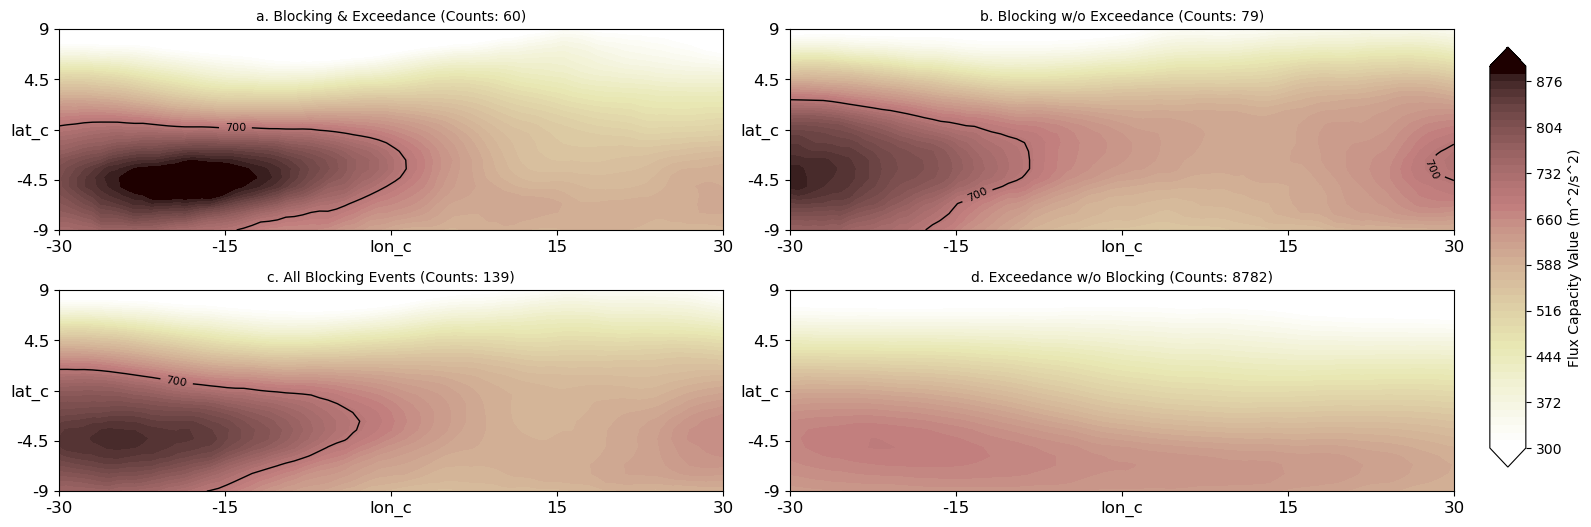

In [7]:
### FIG4 supp low threshold
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1 = np.percentile(extracted_block, 5)
    percentile_99 = np.percentile(extracted_block, 95)
    extracted_block = np.clip(extracted_block, percentile_1, percentile_99)
    return event_type, extracted_block, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Define the function to plot heatmaps
def plot_composite_heatmap(ax, data, title, event_count, norm, levels, cmap):
    lon = np.linspace(-30, 30, data.shape[1])
    lat = np.linspace(-9, 9, data.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)
    contour = ax.contourf(Lon, Lat, data, levels=norm.boundaries, cmap=cmap, norm=norm, extend='both')
    contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f', colors='black')
    ax.set_title(f"{title}", fontsize=10)
    ax.set_xticks([-30, -15, 0, 15, 30])
    ax.set_yticks([-9, -4.5, 0, 4.5, 9])
    ax.set_xticklabels(['-30', '-15', 'lon_c', '15', '30'], fontsize=12)
    ax.set_yticklabels(['-9', '-4.5', 'lat_c', '4.5', '9'], fontsize=12)
    return contour

# Setup for plotting
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 2)

# Color maps
cmap_upper = 'hot_r'
cmap_lower = 'pink_r'

# Norms for the upper and lower rows
norm_upper = BoundaryNorm(np.linspace(0, 800, 51), ncolors=256, clip=True)
norm_lower = BoundaryNorm(np.linspace(300, 900, 51), ncolors=256, clip=True)


# Plot each subplot with a bold title and shared colorbar range
ax1 = fig.add_subplot(gs[0, 0])
contour1 = plot_composite_heatmap(ax1, composite_heatmap_match, f'a. Blocking & Exceedance (Counts: {count_match})', count_match, norm=norm_lower, levels=[700], cmap=cmap_lower)

ax2 = fig.add_subplot(gs[0, 1])
contour2 = plot_composite_heatmap(ax2, composite_heatmap_non_match, f'b. Blocking w/o Exceedance (Counts: {count_non_match})', count_non_match, norm=norm_lower, levels=[700], cmap=cmap_lower)

ax3 = fig.add_subplot(gs[1, 0])
contour3 = plot_composite_heatmap(ax3, composite_heatmap_both, f'c. All Blocking Events (Counts: {count_both})', count_both, norm=norm_lower, levels=[700], cmap=cmap_lower)

ax4 = fig.add_subplot(gs[1, 1])
contour4 = plot_composite_heatmap(ax4, composite_heatmap_exceedance, f'd. Exceedance w/o Blocking (Counts: {count_exceedance})', count_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)

# Add a colorbar on the right side of the grid, associated with the first subplot's image
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
fig.colorbar(contour1, cax=cbar_ax).set_label('Flux Capacity Value (m^2/s^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.show()



100%|██████████| 234/234 [00:04<00:00, 55.81it/s] 


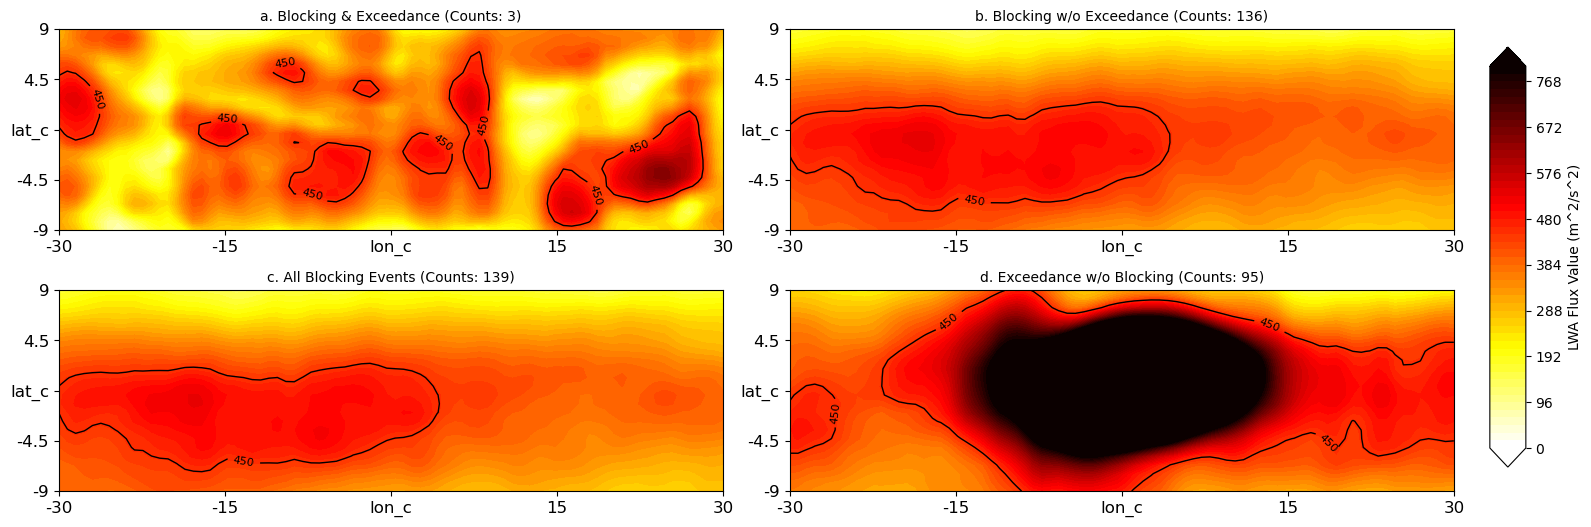

In [9]:
### FIG3 supp high threshold

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
from matplotlib.colors import BoundaryNorm

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = total_flux[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1 = np.percentile(extracted_block, 5)
    percentile_99 = np.percentile(extracted_block, 95)
    extracted_block = np.clip(extracted_block, percentile_1, percentile_99)
    return event_type, extracted_block, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221_high_threshold_1200/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Define the function to plot heatmaps
def plot_composite_heatmap(ax, data, title, event_count, norm, levels, cmap):
    lon = np.linspace(-30, 30, data.shape[1])
    lat = np.linspace(-9, 9, data.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)
    contour = ax.contourf(Lon, Lat, data, levels=norm.boundaries, cmap=cmap, norm=norm, extend='both')
    contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f', colors='black')
    ax.set_title(f"{title}", fontsize=10)
    ax.set_xticks([-30, -15, 0, 15, 30])
    ax.set_yticks([-9, -4.5, 0, 4.5, 9])
    ax.set_xticklabels(['-30', '-15', 'lon_c', '15', '30'], fontsize=12)
    ax.set_yticklabels(['-9', '-4.5', 'lat_c', '4.5', '9'], fontsize=12)
    return contour

# Setup for plotting
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 2)

# Color maps
cmap_upper = 'hot_r'
cmap_lower = 'pink_r'

# Norms for the upper and lower rows
norm_upper = BoundaryNorm(np.linspace(0, 800, 51), ncolors=256, clip=True)
norm_lower = BoundaryNorm(np.linspace(300, 800, 51), ncolors=256, clip=True)


# Plot each subplot with a bold title and shared colorbar range
ax1 = fig.add_subplot(gs[0, 0])
contour1 = plot_composite_heatmap(ax1, composite_heatmap_match, f'a. Blocking & Exceedance (Counts: {count_match})', count_match, norm=norm_upper, levels=[450], cmap=cmap_upper)

ax2 = fig.add_subplot(gs[0, 1])
contour2 = plot_composite_heatmap(ax2, composite_heatmap_non_match, f'b. Blocking w/o Exceedance (Counts: {count_non_match})', count_non_match, norm=norm_upper, levels=[450], cmap=cmap_upper)

ax3 = fig.add_subplot(gs[1, 0])
contour3 = plot_composite_heatmap(ax3, composite_heatmap_both, f'c. All Blocking Events (Counts: {count_both})', count_both, norm=norm_upper, levels=[450], cmap=cmap_upper)

ax4 = fig.add_subplot(gs[1, 1])
contour4 = plot_composite_heatmap(ax4, composite_heatmap_exceedance, f'd. Exceedance w/o Blocking (Counts: {count_exceedance})', count_exceedance, norm=norm_upper, levels=[450], cmap=cmap_upper)

# Add a colorbar on the right side of the grid, associated with the first subplot's image
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
fig.colorbar(contour1, cax=cbar_ax).set_label('LWA Flux Value (m^2/s^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.show()



100%|██████████| 234/234 [00:01<00:00, 143.04it/s]


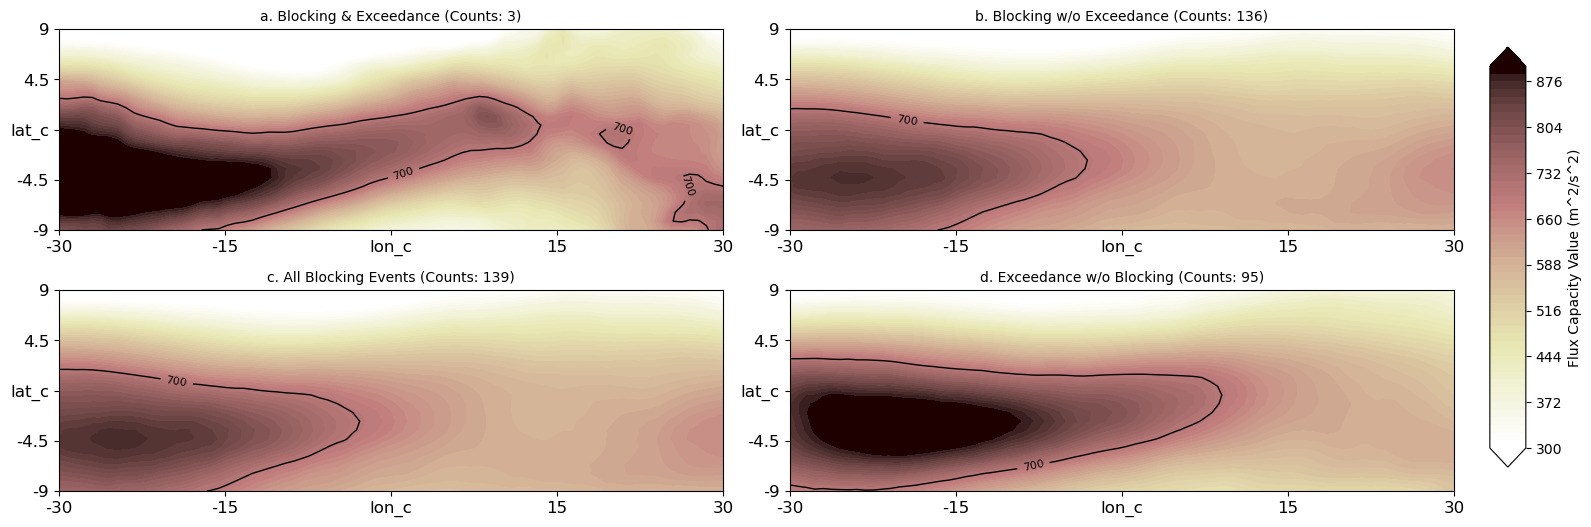

In [10]:
### FIG4 supp high threshold

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import os
from matplotlib.colors import BoundaryNorm

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)

# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx

# Process each event and extract the 30x15 block around the event's center
def process_event(event_type, time_str, lat, lon):
    """
    Process each event to calculate the flux heatmap and extract the 30x15 block around the event's center.
    Handles edge cases for both latitude and longitude wrapping.
    """
    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)
    lat_idx, lon_idx = calculate_grid_index(lat, lon)

    # Define the block size
    lat_block_size = 12  # 15 degrees latitude is 10 steps of 1.5 degrees each
    lon_block_size = 40  # 30 degrees longitude is 20 steps of 1.5 degrees each

    # Initialize an empty block
    extracted_block = np.zeros((lat_block_size * 2, lon_block_size * 2))
    Heaviside_block = np.zeros((lat_block_size * 2, lon_block_size * 2))

    # Calculate the start and end indices, handle wrapping
    for i in range(-lat_block_size, lat_block_size):
        for j in range(-lon_block_size, lon_block_size):
            lat_index = (lat_idx + i) % 121  # Wrap around latitude
            lon_index = (lon_idx + j) % 240  # Wrap around longitude
            extracted_block[i + lat_block_size, j + lon_block_size] = flux_capacity_data[lat_index, lon_index]
            
            # Use Heaviside function for flux comparison
            diff = total_flux[lat_index, lon_index] - flux_capacity_data[lat_index, lon_index]
            Heaviside_block[i + lat_block_size, j + lon_block_size] = np.where(diff > 0, 1, 0)
            
    # Cap the extracted_block values at the 1% and 99% percentiles
    percentile_1 = np.percentile(extracted_block, 5)
    percentile_99 = np.percentile(extracted_block, 95)
    extracted_block = np.clip(extracted_block, percentile_1, percentile_99)
    return event_type, extracted_block, Heaviside_block, (year, month, day, hour), (lat, lon)



# Read the results CSV
results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221_high_threshold_1200/filtered_results_with_hour_difference.csv')


'''
extend to -30 to 30 deg
'''

# Initialize separate heatmaps for each event type
composite_heatmap_match = np.zeros((24, 80))  # 20 steps in lat, 40 steps in lon for the 30x15 degree blocks
composite_heatmap_non_match = np.zeros((24, 80))
composite_heatmap_exceedance = np.zeros((24, 80))
composite_heatmap_both = np.zeros((24, 80))

# Initialize separate Heaviside blocks for each event type
composite_Heaviside_match = np.zeros((24, 80))
composite_Heaviside_non_match = np.zeros((24, 80))
composite_Heaviside_exceedance = np.zeros((24, 80))
composite_Heaviside_both = np.zeros((24, 80))

# Counters for averaging
count_match, count_non_match, count_exceedance, count_both = 0, 0, 0, 0

# Use Joblib to process events in parallel and extract the blocks
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    event_type, block, Heaviside, datetime_info, location_info = process_event(
        row.EventType, 
        row.Time, 
        row.Latitude, 
        row.Longitude
    )


    if event_type == 'Match':
        composite_heatmap_match += block
        composite_heatmap_both += block
        composite_Heaviside_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_match += 1
        count_both += 1
    elif event_type == 'Non-Match':
        composite_heatmap_non_match += block
        composite_heatmap_both += block
        composite_Heaviside_non_match += Heaviside
        composite_Heaviside_both += Heaviside
        count_non_match += 1
        count_both += 1
    elif event_type == 'Exceedance':
        composite_heatmap_exceedance += block
        composite_Heaviside_exceedance += Heaviside
        count_exceedance += 1

# Calculate the averages for the composite heatmaps
composite_heatmap_match /= count_match if count_match else 1
composite_heatmap_non_match /= count_non_match if count_non_match else 1
composite_heatmap_exceedance /= count_exceedance if count_exceedance else 1
composite_heatmap_both /= count_both if count_both else 1

composite_Heaviside_match /= count_match if count_match else 1
composite_Heaviside_non_match /= count_non_match if count_non_match else 1
composite_Heaviside_exceedance /= count_exceedance if count_exceedance else 1
composite_Heaviside_both /= count_both if count_both else 1


# Define the function to plot heatmaps
def plot_composite_heatmap(ax, data, title, event_count, norm, levels, cmap):
    lon = np.linspace(-30, 30, data.shape[1])
    lat = np.linspace(-9, 9, data.shape[0])
    Lon, Lat = np.meshgrid(lon, lat)
    contour = ax.contourf(Lon, Lat, data, levels=norm.boundaries, cmap=cmap, norm=norm, extend='both')
    contour_lines = ax.contour(Lon, Lat, data, levels=levels, colors='black', linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f', colors='black')
    ax.set_title(f"{title}", fontsize=10)
    ax.set_xticks([-30, -15, 0, 15, 30])
    ax.set_yticks([-9, -4.5, 0, 4.5, 9])
    ax.set_xticklabels(['-30', '-15', 'lon_c', '15', '30'], fontsize=12)
    ax.set_yticklabels(['-9', '-4.5', 'lat_c', '4.5', '9'], fontsize=12)
    return contour

# Setup for plotting
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 2)

# Color maps
cmap_upper = 'hot_r'
cmap_lower = 'pink_r'

# Norms for the upper and lower rows
norm_upper = BoundaryNorm(np.linspace(0, 800, 51), ncolors=256, clip=True)
norm_lower = BoundaryNorm(np.linspace(300, 900, 51), ncolors=256, clip=True)


# Plot each subplot with a bold title and shared colorbar range
ax1 = fig.add_subplot(gs[0, 0])
contour1 = plot_composite_heatmap(ax1, composite_heatmap_match, f'a. Blocking & Exceedance (Counts: {count_match})', count_match, norm=norm_lower, levels=[700], cmap=cmap_lower)

ax2 = fig.add_subplot(gs[0, 1])
contour2 = plot_composite_heatmap(ax2, composite_heatmap_non_match, f'b. Blocking w/o Exceedance (Counts: {count_non_match})', count_non_match, norm=norm_lower, levels=[700], cmap=cmap_lower)

ax3 = fig.add_subplot(gs[1, 0])
contour3 = plot_composite_heatmap(ax3, composite_heatmap_both, f'c. All Blocking Events (Counts: {count_both})', count_both, norm=norm_lower, levels=[700], cmap=cmap_lower)

ax4 = fig.add_subplot(gs[1, 1])
contour4 = plot_composite_heatmap(ax4, composite_heatmap_exceedance, f'd. Exceedance w/o Blocking (Counts: {count_exceedance})', count_exceedance, norm=norm_lower, levels=[700], cmap=cmap_lower)

# Add a colorbar on the right side of the grid, associated with the first subplot's image
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as needed for [left, bottom, width, height]
fig.colorbar(contour1, cax=cbar_ax).set_label('Flux Capacity Value (m^2/s^2)')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.show()

